# Forecasting Daily Hotel Cancellations with CNN

#### Attributions

The below code uses the template from the [Intro to TensorFlow for Deep Learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187) tutorial, of which the original authors **(Copyright 2018 The TensorFlow Authors)** have made available under the Apache 2.0 license.

Modifications have been made to the below code for the purpose of generating appropriate analyses on the hotel cancellations dataset. The original source code can be found [here](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb#scrollTo=PgYwn9VM8OJi).

The data used in this example is sourced from [Antonio, Almeida and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The below work and findings are not endorsed by the original authors in any way.

#### Apache 2.0 Licence

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(1234)

keras = tf.keras

In [3]:
from numpy.random import seed
seed(1)
from pandas import DataFrame

dtypes = {
        'IsCanceled':                                    'float64',
        }

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
df = pd.read_csv("daily cancellations h1.csv", dtype=dtypes)
df

FullDate  IsCanceled
0    20150701         5.0
1    20150702         9.0
2    20150703        13.0
3    20150704        14.0
4    20150705         8.0
..        ...         ...
788  20170827        21.0
789  20170828        37.0
790  20170829        14.0
791  20170830        14.0
792  20170831        14.0

[793 rows x 2 columns]

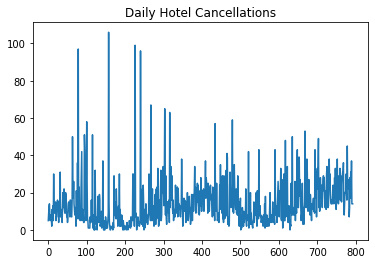

In [6]:
series = df['IsCanceled']
series=np.array(series)
plt.plot(series)
plt.title("Daily Hotel Cancellations")
plt.show()

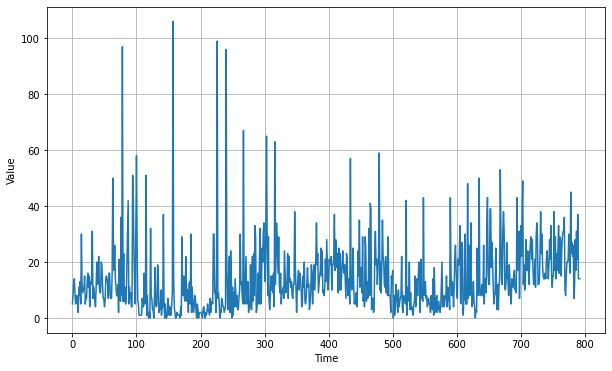

In [7]:
time = np.arange(0, 793)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [8]:
split_time = 634
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=32)
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [10]:
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
19/19 [==============================] - 0s 7ms/step - loss: 142.0207 - mae: 142.5207 - lr: 1.0000e-08
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 139.0442 - mae: 139.5440 - lr: 1.1220e-08
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 134.9950 - mae: 135.4949 - lr: 1.2589e-08
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 130.0892 - mae: 130.5892 - lr: 1.4125e-08
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 124.1411 - mae: 124.6411 - lr: 1.5849e-08
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 116.7640 - mae: 117.2639 - lr: 1.7783e-08
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 107.5714 - mae: 108.0714 - lr: 1.9953e-08
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 96.3573 - mae: 96.8572 - lr: 2.2387e-08
Epoch 9/100
19/19 [==============================] - 0s 6ms/step - loss: 83.9005 -

Epoch 73/100
19/19 [==============================] - 0s 10ms/step - loss: 7.2039 - mae: 7.6850 - lr: 3.9811e-05
Epoch 74/100
19/19 [==============================] - 0s 10ms/step - loss: 6.7721 - mae: 7.2498 - lr: 4.4668e-05
Epoch 75/100
19/19 [==============================] - 0s 11ms/step - loss: 7.3066 - mae: 7.7897 - lr: 5.0119e-05
Epoch 76/100
19/19 [==============================] - 0s 10ms/step - loss: 7.2284 - mae: 7.7099 - lr: 5.6234e-05
Epoch 77/100
19/19 [==============================] - 0s 11ms/step - loss: 6.8618 - mae: 7.3411 - lr: 6.3096e-05
Epoch 78/100
19/19 [==============================] - 0s 11ms/step - loss: 6.7597 - mae: 7.2392 - lr: 7.0795e-05
Epoch 79/100
19/19 [==============================] - 0s 11ms/step - loss: 7.3124 - mae: 7.7934 - lr: 7.9433e-05
Epoch 80/100
19/19 [==============================] - 0s 11ms/step - loss: 14.6367 - mae: 15.1318 - lr: 8.9125e-05
Epoch 81/100
19/19 [==============================] - 0s 12ms/step - loss: 13.6812 - mae: 14.1

(1e-08, 0.0001, 0.0, 30.0)

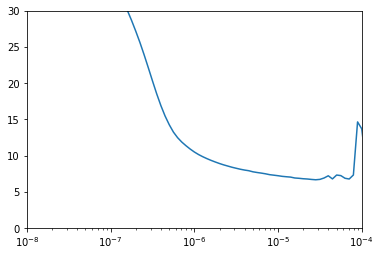

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [12]:
model = keras.models.load_model("my_checkpoint.h5")

In [13]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

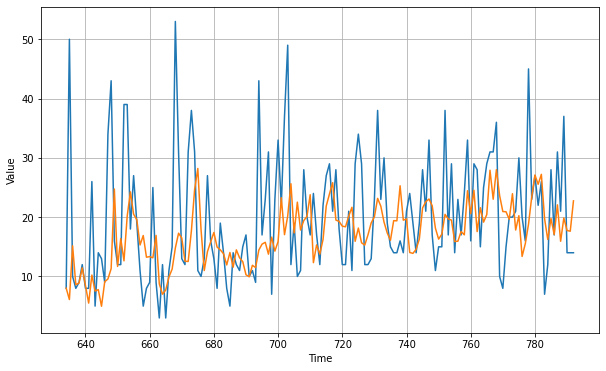

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.377962

In [16]:
np.mean(x_valid)

19.89308176100629

## Fully Convolutional Forecasting

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h6", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      4/Unknown - 0s 14ms/step - loss: 11.5507 - mae: 12.0378WARNING:tensorflow:From /home/michael/.local/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
5/5 [==============================] - 2s 379ms/step - loss: 11.5598 - mae: 12.0468 - val_loss: 18.4603 - val_mae: 18.9603
Epoch 2/500
5/5 [==============================] - 1s 280ms/step - loss: 11.2196 - mae: 11.7052 - val_loss: 17.8274 - val_mae: 18.3274
Epoch 3/500
5/5 [==============================] - 2s 323ms/step - loss: 10.7954 - mae: 11.2805 - val_loss: 16.9725 - val_mae: 17.4723
Epoch 4/500
5/5 [==============================] - 1s 294ms/step - loss: 10.2919 - mae: 10.7764 - val_loss: 

5/5 [==============================] - 2s 305ms/step - loss: 6.7976 - mae: 7.2746 - val_loss: 7.4280 - val_mae: 7.9120
Epoch 32/500
5/5 [==============================] - 0s 18ms/step - loss: 6.7678 - mae: 7.2442 - val_loss: 7.4466 - val_mae: 7.9289
Epoch 33/500
5/5 [==============================] - 1s 273ms/step - loss: 6.7387 - mae: 7.2137 - val_loss: 7.3810 - val_mae: 7.8659
Epoch 34/500
5/5 [==============================] - 1s 298ms/step - loss: 6.7118 - mae: 7.1869 - val_loss: 7.3410 - val_mae: 7.8268
Epoch 35/500
5/5 [==============================] - 0s 18ms/step - loss: 6.6856 - mae: 7.1589 - val_loss: 7.3528 - val_mae: 7.8375
Epoch 36/500
5/5 [==============================] - 1s 281ms/step - loss: 6.6580 - mae: 7.1304 - val_loss: 7.2724 - val_mae: 7.7578
Epoch 37/500
5/5 [==============================] - 0s 18ms/step - loss: 6.6342 - mae: 7.1070 - val_loss: 7.2742 - val_mae: 7.7588
Epoch 38/500
5/5 [==============================] - 0s 20ms/step - loss: 6.6098 - mae: 7.080

In [18]:
model = keras.models.load_model("my_checkpoint.h6")

In [19]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

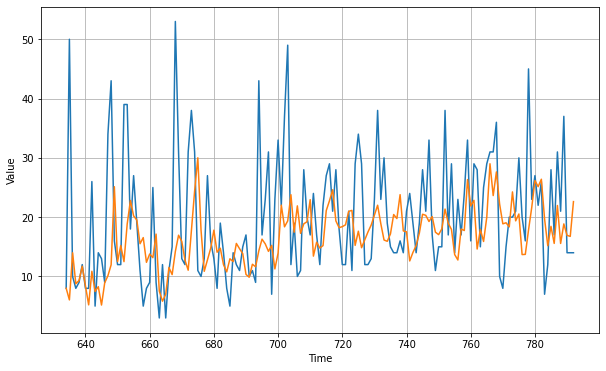

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [21]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

7.490844